# ２項分類のチュートリアル

In [1]:
import sklearn
print('sklearn version : ' + sklearn.__version__)

sklearn version : 0.24.0


## データセットのダウンロード

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

X = mnist['data'].to_numpy()#pandas.DataFrame->nparrayの変換
y = mnist['target'].to_numpy()
print('X.shape : ' + str(X.shape))
print('y.shape : ' + str(y.shape))

X.shape : (70000, 784)
y.shape : (70000,)


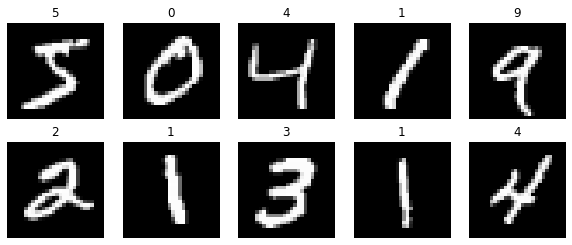

In [16]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#画像のサイズ設定
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)#subplot番号は1始まり
    plt.imshow(X[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
    plt.title(y[i])